In [1]:
import os

os.chdir(r'C:\Users\carlo\GitHub\ProjectBuffalo')

In [2]:
import pandas as pd
import numpy as np
import buffalo.algorithm.outliers as ol_algo

In [3]:
import buffalo.predictor as predictor

## Apple Outlier Detection

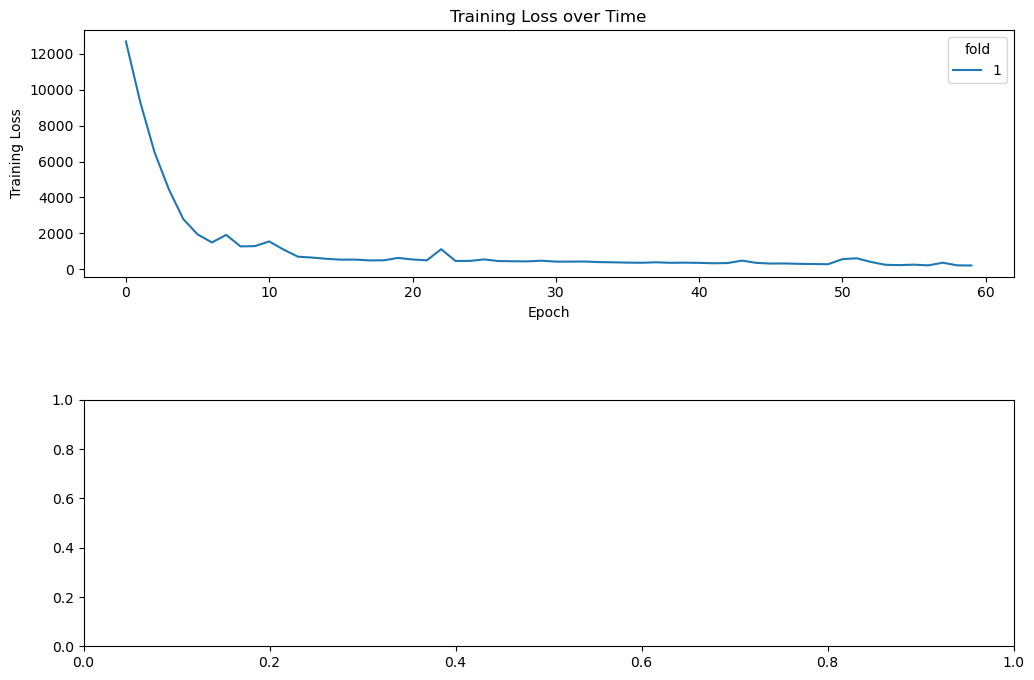

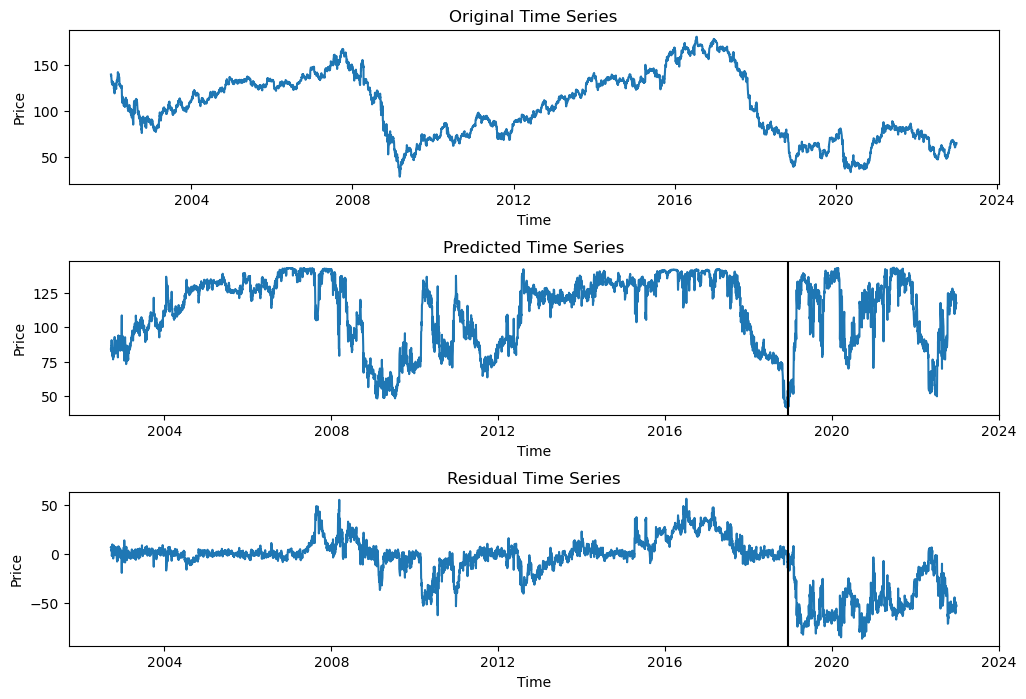

In [10]:
model_performance = predictor.ModelPerformance.deserialize_from_file(r'cached_data/record.sqlite', testing_id=39)
model_performance.plot_training_records()
model_performance.plot_residuals()

In [7]:
def outlier_detection_pipeline(test_id, plot=False):
    model_performance = predictor.ModelPerformance.deserialize_from_file(r'cached_data/record.sqlite', testing_id=test_id)
    if plot:
        model_performance.plot_residuals()
    ol_detection = ol_algo.IterativeTtestOutlierDetection(
        types= pd.DataFrame({'type': ['AO', 'IO', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC'], 'delta': [0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}),
        maxit=4,
        maxit_iloop=4,
        maxit_oloop=4,
        cval=None,
        cval_reduce=0.14286,
        discard_method='bottom-up',
        discard_cval=3.5,
        tsmethod='ARIMA',
        args_tsmethod={
            "order": (1,0,0),
            "seasonal_order": (0, 0, 0, 0),
            "with_intercept": True
        }
    )
    series = model_performance.get_endog_resid_predicted().dropna()
    series = series[series['is_train']]
    ol_detection_result = ol_detection.fit(endog=model_performance.training_residuals['residual'], exog=None)
    ol_detection_result.serialize_to_file(sql_path=r'cached_data/ol_detection_result.sqlite', dataset_name=f'testing_id_{test_id}', algo_name='VC not included')
    if plot:
        ol_detection_result.plot_series_decomposition()
    return ol_detection_result

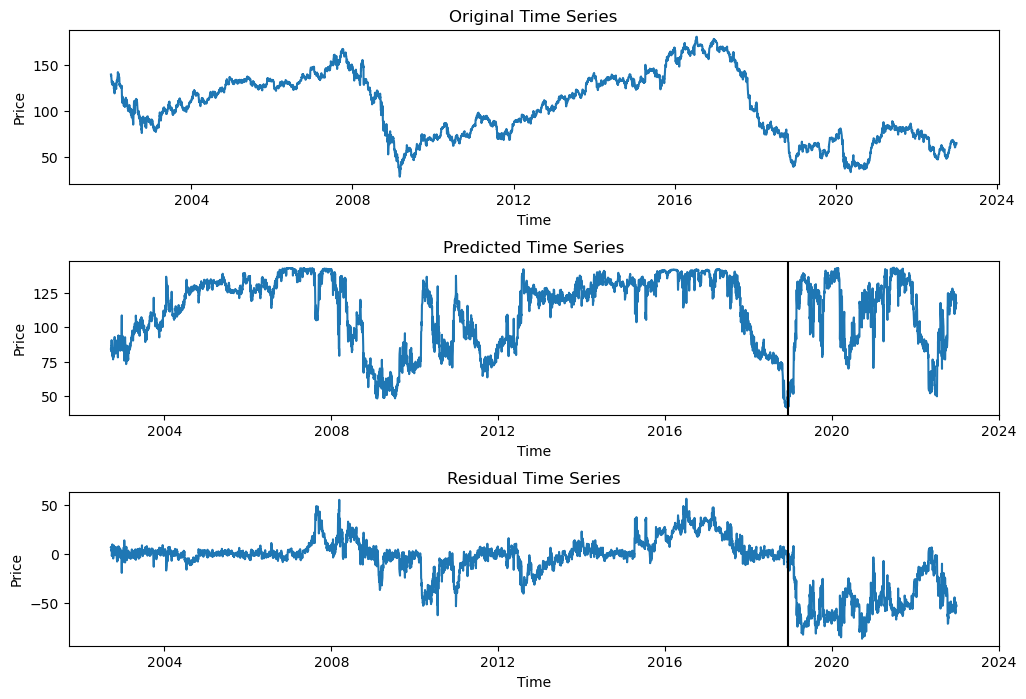

C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\algorithm\outliers.py:675: UserWarning: Maximum number of iterations reached for inner loop.
  warn('Maximum number of iterations reached for inner loop.')
C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\algorithm\outliers.py:675: UserWarning: Maximum number of iterations reached for inner loop.
  warn('Maximum number of iterations reached for inner loop.')
c:\Users\carlo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Users\carlo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Users\carlo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init

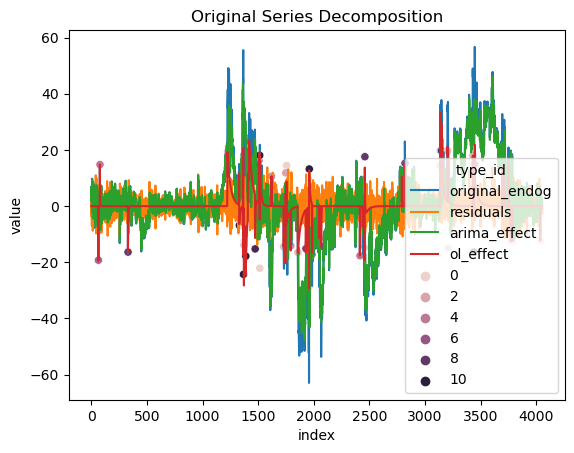

In [8]:
ol_detection_result = outlier_detection_pipeline(35, True)

In [ ]:
import os

os.chdir(r'C:\Users\carlo\GitHub\ProjectBuffalo')

import buffalo.ingestion as ingestion
import buffalo.predictor as predictor
import buffalo.algorithm as algorithm
import buffalo.predictor.models as modeling
import torch
import pickle
import pandas as pd
from buffalo.utility import expand_grid
from tqdm.auto import tqdm

In [ ]:
outlier_result = algorithm.outliers.IterativeTtestOutlierDetectionResult.deserialize_from_file(r'cached_data/ol_detection_result.sqlite', 1)

In [ ]:
outlier_result.plot_series_decomposition()

In [ ]:
outlier_result.original_endog


In [ ]:
outlier_result.located_ol

In [ ]:
outlier_result.adjusted_endog

In [ ]:
outlier_result.exog

In [ ]:
target_symbol = 'AAPL'

In [ ]:
import buffalo.predictor.models as modeling

In [ ]:
outlier_result.endog

In [ ]:
## Create dataset
concat = pd.concat([target_stock['adjusted_close'], outlier_result.ol_effect], axis=1)
outlier_dataset = predictor.TimeSeriesData(endog=pd.DataFrame(outlier_result.ol_effect), exog=pd.DataFrame(outlier_result.adjusted_endog), seq_len=180, label_len=1, name='OutlierDetection')

In [ ]:
rnn = modeling.RNN(
    input_size=2,
    n_ahead=1,
    hidden_size=32,
    output_size=1,
    num_layers=2,
    dropout=0.1,
    bidirectional=True,
    use_gpu=True)
optimizer = torch.optim.Adam(
    rnn.parameters(),
    lr=0.001,
    weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = predictor.train_and_evaluate_model(
    rnn,
    optimizer,
    loss_func,
    outlier_dataset ,
    epochs_per_fold=20,
    test_ratio=0.2,
    n_fold=4,
    clip_grad=1,
    batch_size=64) # Pointwise prediction
    #training_record.serialize_to_file(r'cached_data/residual_record.sqlite', additional_note_dataset='', additonal_note_model='')

In [ ]:
training_record.plot_training_records()

In [ ]:
training_record.plot_residuals()

In [ ]:
rnn = modeling.LSTM(
    input_size=2,
    n_ahead=1,
    hidden_size=32,
    output_size=1,
    num_layers=2,
    dropout=0.1,
    bidirectional=True,
    use_gpu=True)
optimizer = torch.optim.Adam(
    rnn.parameters(),
    lr=0.0001,
    weight_decay=0.0001)
loss_func = torch.nn.MSELoss()
training_record = predictor.train_and_evaluate_model(
    rnn,
    optimizer,
    loss_func,
    outlier_dataset ,
    epochs_per_fold=30,
    test_ratio=0.2,
    n_fold=4,
    clip_grad=1,
    batch_size=32) # Pointwise prediction
    #training_record.serialize_to_file(r'cached_data/residual_record.sqlite', additional_note_dataset='', additonal_note_model='')

In [ ]:
training_record.plot_training_records()

In [ ]:
training_record.plot_residuals()

In [ ]:
sweep_params = expand_grid(
    hidden_size=[32, 128],
    num_layers=[1, 3],
    dropout=[0.0, 0.2],
    batch_size=[32, 64, 128],
    learning_rate=[0.001, 0.0001],
    weight_decay=[0.001, 0.0001],
    epochs=[20, 30],
    bidirectional = [True, False],
    n_fold=1
)

In [ ]:
sweep_params

In [ ]:
for i in tqdm(range(795, sweep_params.shape[0])):
    param = sweep_params.loc[i,:].to_dict()
    rnn = modeling.RNN(
        input_size=2,
        n_ahead=n_head,
        hidden_size=param['hidden_size'],
        output_size=1,
        num_layers=param['num_layers'],
        dropout=param['dropout'],
        bidirectional=param['bidirectional'],
        use_gpu=False)
    optimizer = torch.optim.Adam(
        rnn.parameters(),
        lr=param['learning_rate'],
        weight_decay=param['weight_decay'])
    loss_func = torch.nn.MSELoss()
    training_record = predictor.train_and_evaluate_model(
        rnn,
        optimizer,
        loss_func,
        outlier_dataset ,
        epochs_per_fold=param['epochs'],
        test_ratio=0.2,
        n_fold=param['n_fold'],
        clip_grad=1,
        batch_size=param['batch_size']) # Pointwise prediction
    #training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')

In [ ]:
outlier_result.ol_effect.shape[0]